# HW 5 Assignment 1
Nurvirta Monarizqa (nm2773)

Here, I use citibike data from June 2016

In [1]:
from zipfile import ZipFile
try:
    from StringIO import StringIO as sio
except ImportError:
    from io import BytesIO as sio
try:
    from urllib2 import urlopen
except ImportError:
    from urllib.request import urlopen
import pandas as pd

#opening file into this notebook
r = urlopen('https://s3.amazonaws.com/tripdata/201606-citibike-tripdata.zip').read()
z = ZipFile(sio(r))
citibikedata = z.open('201606-citibike-tripdata.csv')
data = pd.read_csv(citibikedata)
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1470,6/1/2016 00:00:18,6/1/2016 00:24:48,380,W 4 St & 7 Ave S,40.734011,-74.002939,3236,W 42 St & Dyer Ave,40.758985,-73.993800,19859,Subscriber,1972.0,1
1,229,6/1/2016 00:00:20,6/1/2016 00:04:09,3092,Berry St & N 8 St,40.719009,-73.958525,3103,N 11 St & Wythe Ave,40.721533,-73.957824,16233,Subscriber,1967.0,1
2,344,6/1/2016 00:00:21,6/1/2016 00:06:06,449,W 52 St & 9 Ave,40.764618,-73.987895,469,Broadway & W 53 St,40.763441,-73.982681,22397,Subscriber,1989.0,1
3,1120,6/1/2016 00:00:28,6/1/2016 00:19:09,522,E 51 St & Lexington Ave,40.757148,-73.972078,401,Allen St & Rivington St,40.720196,-73.989978,16231,Subscriber,1991.0,1
4,229,6/1/2016 00:00:53,6/1/2016 00:04:42,335,Washington Pl & Broadway,40.729039,-73.994046,285,Broadway & E 14 St,40.734546,-73.990741,15400,Subscriber,1989.0,1


# data cleaning and data exploration

In [43]:
data['age'] = 2016 - data['birth year']
data.age.head()

0    44.0
1    49.0
2    27.0
3    25.0
4    27.0
Name: age, dtype: float64

In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(16838920)

In [44]:
data['age'].dropna(inplace = True)
data2 = data['age']
dmean = data2.mean()
dstd = data2.std()
data2_norm = (data2 - dmean)/dstd

a = data.usertype.groupby(data.age).agg([np.count_nonzero])

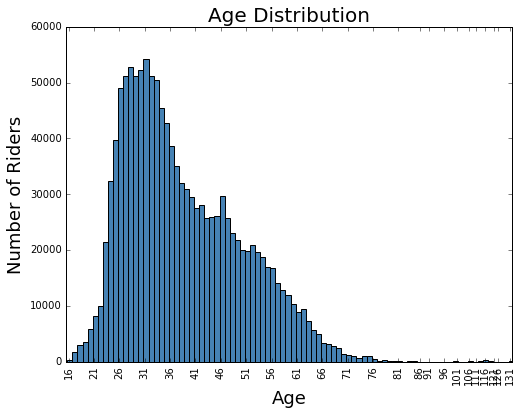

Mean of distribution = 38.3405817034
Standard deviation of distribution = 11.5771650938


In [45]:
ax = a.plot(kind='bar',figsize = (8,6),color ='steelblue',legend=False)
ax.set_title("Age Distribution", fontsize = 20)
plt.ylabel("Number of Riders", fontsize = 18)
plt.xlabel("Age", fontsize = 18)
for container in ax.containers:
    plt.setp(container, width=1)
new_ticks = np.arange(16, 135, 5)
ax.set_xticks(np.interp(new_ticks, a.index, np.arange(a.size)))
ax.set_xticklabels(new_ticks)
plt.show()
print 'Mean of distribution = ' + str(dmean)
print 'Standard deviation of distribution = ' +str(dstd)

#### Figure 1: Age distribution of citibike riders
As we can see, the distribution is skewed rather than following normal distribution. It does not follow central limit theorem as well because we do not calculate arithmetic means of its samples.

# GOODNESS OF FIT
Method: KS test and Chi-square

Distribution to be compared: normal (gaussian), gamma, and skewnorm

## function creation
Here I made 2 function, first is `plot_comparison` to show and compare citibike age distribution with the selected distribution. 

The second one is `calc_chisq`. Chisquare formula works best for under 2500 datapoints while we have more than 100k samples. So here I did sampling for about 500 each, then put them in bins (age). I also get rid all the data under 4 numbers of events. We will test the chisquare between frequency of both binned sets. There are 2 formulas here:
1. Using `scipy.stats.chisquare`
2. Using my manual calculation according to [this link.](http://www.aip.de/groups/soe/local/numres/bookcpdf/c14-3.pdf)

$$ \chi^2 = \sum_{i} \frac{(\sqrt{S/R}R_i - \sqrt{R/S}S_i)^2}{R_i + S_i}$$

With $R_i$ be the frequency in bin i for the first dataset, $S_i$ the frequency in the same bin i for the second dataset, and R,S both the total number of datapoints for first and second set respectively.

In [15]:
import scipy.stats
def plot_comparison(k,dist):
    plt.figure(figsize = (8,8))
    plt.subplot(211)
    g = eval('scipy.stats.'+dist+'.rvs(k, size=1265112)')
    data2_norm = ((data2 - dmean)/dstd)*g.std() + g.mean()
    agedist = plt.hist(data2_norm,bins = 56, label = 'citibike age')
    comparedist = plt.hist(g,bins = 56, alpha = 0.6,label = dist+' distribution')
    
    plt.xlim(min(comparedist[1]),max(comparedist[1]))
    plt.title('Citibike age distribution vs ' + dist + ' distribution')
    plt.ylabel('n riders')
    plt.legend()
    
    plt.subplot(223)
    csum = np.cumsum((agedist[1][2]-agedist[1][1])*agedist[0])
    b = csum/max(csum)
    csum2 = np.cumsum((comparedist[1][2]-comparedist[1][1])*comparedist[0])
    c = csum2/max(csum2)
    plt.plot(b)
    plt.plot(c)
    plt.xlim(0,57)
    plt.title('cumulative sum')
    
    plt.subplot(224)
    plt.plot(abs(b-c), 'r')
    plt.plot(np.zeros(57),'k--')
    plt.xlim(0,57)
    plt.ylim(0,1)
    plt.title('differences')
    
    return data2_norm

# calculate chisquare:
def calc_chisq(data,dist,k):
    obs = data.copy()
    obs.index = range(len(obs))
    sample_obs = obs[np.linspace(0,len(obs)-1,500).astype(int)]
    sample_obs.sort_values(inplace=True)
    b = sample_obs.groupby(sample_obs).agg([np.count_nonzero])
    sample_exp = eval('scipy.stats.'+dist+'.rvs(k, size=500)')
    
    plt.hist(sample_obs,bins=len(b), alpha = 0.6, label='citibike sample')
    a = plt.hist(sample_exp,bins=len(b), alpha=0.6, label = dist+' sample')
    plt.legend()

    df = pd.DataFrame({'obs':b.count_nonzero.values,
                      'exp':a[0]})
    df = df[(df.obs >= 4) & (df.exp >= 4)].copy()
    k1 = np.sqrt(df.exp.sum()/df.obs.sum())
    k2 = np.sqrt(df.obs.sum()/df.exp.sum())
    df["chi"]= ((k1*df.obs -k2*df.exp)**2)/(df.obs +df.exp)
    print 'critical value 0.05 = ' + str(scipy.stats.chi2.ppf(q=0.95,df=len(df)-1))
    print 'critical value 0.25 = ' + str(scipy.stats.chi2.ppf(q=0.75,df=len(df)-1))
    print 'chi square - manual calculation = ' + str(df.chi.sum())
    print 'chi square by formula = ' + str(scipy.stats.chisquare(f_obs = df.obs, f_exp=df.exp))

# RESULT
## 1. normal

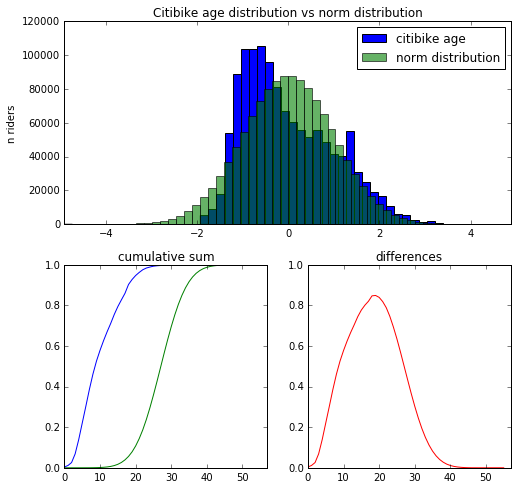

In [20]:
data2_norm = plot_comparison(0,'norm')

Figure 2: Citibike age distribution vs standard normal distribution. We can see that the normal distribution that we created fromm 100k+ data is representing the standard normal distribution very well, as stated in the central limit theorem where the larger the data, the more likely it shows the parent distribution's shape. Also in figure 2, we can see that both histograms are not overlapping very well, meaning they appear not fit.

Null hypothesis: the citibike sample ages does comes from the standard normal distribution, or we can say that the standard normal distribution ($D_{normal}$) is fit to the citibike age distribution ($D_{citibike}$)

$H_0$ : $D_{citibike}$ = $D_{normal}$

$H_1$ : $D_{citibike} \neq D_{normal}$

$\alpha = 0.05$

#### KS test:

In [21]:
import scipy.stats
scipy.stats.kstest(data2_norm,'norm')

KstestResult(statistic=0.10905447741752167, pvalue=0.0)

#### Chi-Square test

critical value 0.05 = 43.7729718257
critical value 0.25 = 34.7997425191
chi square - manual calculating = 72.534496694
chi square by formula = Power_divergenceResult(statistic=169.88418535723861, pvalue=1.7967265528124032e-21)


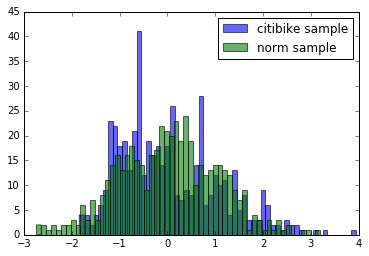

In [22]:
calc_chisq(data2_norm,'norm',0)

Figure 2.1: as we only had 500 samples for each distribution, according to CLT, they do not represent their parent distribution very well.

Both of the test return very small p-values. In my manual calculation, it also returns a number way larger than the critical value of 0.05. So, it is **HIGHLY UNLIKELY THAT $H_0$ IS TRUE**, $H_0$ is rejected.

# 2. gamma

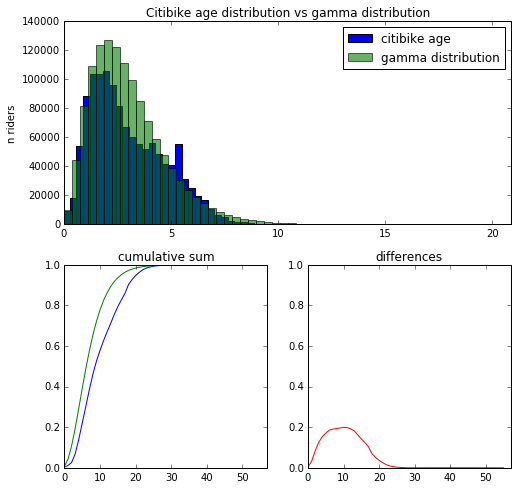

In [25]:
k = 3
data2_gamma = plot_comparison(k,'gamma')

Figure 3: Citibike age distribution vs gamma distribution. Similar with the previous normal distribution, we can see that the gamma distribution that we created from 100k+ data is representing the gamma distribution very well, as stated in the central limit theorem where the larger the data, the more likely it shows the parent distribution's shape. But, different from previous distribution, it seems the gamma distribution fits citibike distribution better than the normal distribution.

Null hypothesis: the citibike sample ages does comes from gamma distribution, or we can say that the gamma ($D_{gamma}$) is fit to the citibike age distribution ($D_{citibike}$)

$H_0$ : $D_{citibike}$ = $D_{gamma}$

$H_1$ : $D_{citibike} \neq D_{gamma}$

$\alpha = 0.05$

#### KS test

In [26]:
scipy.stats.kstest(data2_gamma,'gamma', args = (k,))

KstestResult(statistic=0.049587823654667962, pvalue=0.0)

#### Chi-Square test

critical value 0.05 = 42.5569678043
critical value 0.25 = 33.7109086039
chi square - manual calculating = 82.775172596
chi square by formula = Power_divergenceResult(statistic=164.90189945532049, pvalue=5.9380758710576044e-21)


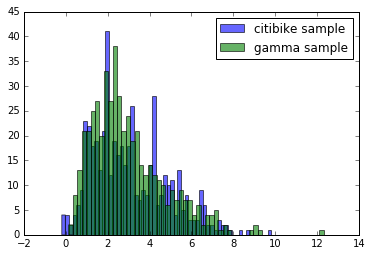

In [27]:
calc_chisq(data2_gamma,'gamma',3)

Figure 3.1: as we only had 500 samples for each distribution, according to CLT, they do not represent their parent distribution very well.

KS test returns statistic value smaller than normal distribution's, meaning, it fits better than the normal one. But eventhough it fits better, the KS p value and chisquare p value are still, very small. Indicating that **H0 is still highly unlikely to be true**. Both distributions are different.

# 3. skewnorm

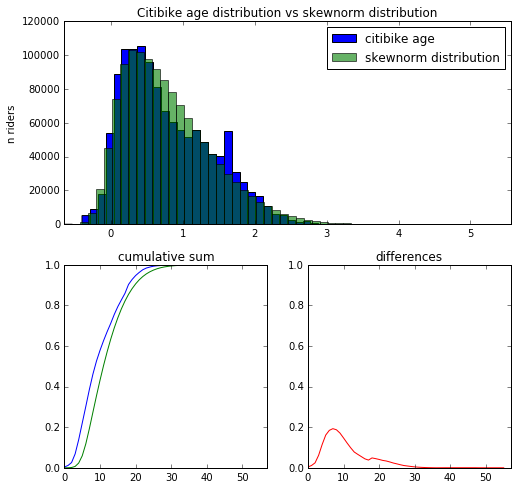

In [29]:
k = 6
data2_skewnorm = plot_comparison(6,'skewnorm')

Figure 4: Citibike age distribution vs skewnorm distribution. Compared to the previous distributions, this one fits the best. We can see that the differences between cumulative sums are the lowest. Most of the skewnorm histogram bins overlaps the age distribution bins. As the number of samples is very large, we can see that the skewnorm depict the real skewnorm distribution (CLT).

Null hypothesis: the citibike sample ages does comes from the skewnorm distribution, or we can say that the skewnorm distribution ($D_{skewnorm}$) is fit to the citibike age distribution ($D_{citibike}$)

$H_0$ : $D_{citibike}$ = $D_{skewnorm}$

$H_1$ : $D_{citibike} \neq D_{skewnorm}$

$\alpha = 0.05$

In [38]:
scipy.stats.kstest(data2_skewnorm,'skewnorm', args = (k,))

KstestResult(statistic=0.040852601255571663, pvalue=0.0)

critical value 0.05 = 50.9984601657
critical value 0.25 = 41.3036155334
chi square - manual calculating = 28.1102617871
chi square by formula = Power_divergenceResult(statistic=61.031670485666645, pvalue=0.0057009598736928388)


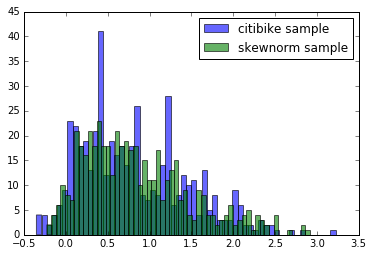

In [37]:
calc_chisq(data2_skewnorm,'skewnorm',6)

Figure 4.1: as we only had 500 samples for each distribution, according to CLT, they do not represent their parent distribution very well.

This skewnorm distribution really fit the age distribution the best, compared to the previous distributions, as the KS test returns the smallest value among the others. But still, chi-square p value is < 0.05 even though it is largest than the others. So, unfortunately, we have to admit that **H0 is unlikely to be true**, the age sample does not come from the skewnorm distribution.